# MINST

## 1 Data

### 1.1 get data

- use panadas to read data from .csv file

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../DATA/train.csv')

In [3]:
labels = df.as_matrix(columns=['label'])

In [4]:
dataset = df.drop('label', axis=1).as_matrix()

In [5]:
print('Got', len(dataset), 'training examples(with', len(labels), 'labels).')

Got 4200 training examples(with 4200 labels).


In [6]:
df = pd.read_csv('DATA/train.csv')
labels = df.as_matrix(columns=['label'])#find lable to transform to matrix
dataset = df.drop('label', axis=1).as_matrix()#transform dataset to matrxi without drop lable 
print('Got', len(dataset), 'training examples (with', len(labels), 'labels).')

Got 4200 training examples (with 4200 labels).


- split dataset into training and validation datasets

In [7]:
train_len = int(len(labels.ravel()) * 0.75)
train_dataset = dataset[:train_len]
train_labels = labels[:train_len]
valid_dataset = dataset[train_len:]
valid_labels = labels[train_len:]

### 1.2 plot

- we can use matplotlib to get better understanding of the data

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def display_sample(dataset, rows=4, colunms=5):
    index = 1
    for image in dataset[:rows*colunms]:
        img = np.reshape(image, [28, 28])
        plt.subplot(rows, colunms, index)
        plt.axis('off')
        plt.imshow(img)
        index += 1
    plt.show()

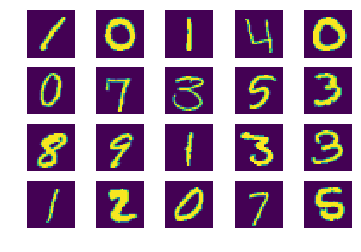

In [10]:
display_sample(train_dataset)

### 1.3 Data validation

In [11]:
def count_each_label(labels):
    counters = np.zeros(10, int)
    for i in range(len(labels)):
        counters[labels[i]] += 1
    for i in range(10):
        print(i, ':', counters[i])
    print('\nmin:\t%d' % np.min(counters))
    print('mean:\t%d' % np.mean(counters))
    print('max:\t%d' % np.max(counters))
    print('stddev:\t%.2f' % np.std(counters))

In [12]:
count_each_label(train_labels)

0 : 319
1 : 354
2 : 343
3 : 286
4 : 310
5 : 301
6 : 320
7 : 318
8 : 295
9 : 304

min:	286
mean:	315
max:	354
stddev:	19.84


## 2 Logistic Regression

- First, using off-the-shelf classifier,it can give you a how result

In [13]:
def off_the_shelf():
    from sklearn.linear_model import LogisticRegression
    
    logreg = LogisticRegression(solver='sag', max_iter=256)
    %time logreg.fit(train_dataset, train_labels.ravel())
    
    print('Acc on train dataset: {:.2%}'.format(logreg.score(train_dataset, train_labels)))
    print('Acc on valid dataset: {:.2%}'.format(logreg.score(valid_dataset, valid_labels)))

In [14]:
off_the_shelf()

C:\Users\htfenght\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Wall time: 1min 11s
Acc on train dataset: 99.30%
Acc on valid dataset: 86.57%


** one-Hot encoding **

In [15]:
def one_hot_encode(labels, classes=10):
    one_hot = np.zeros([len(labels), 10])
    for i in range(len(labels)):
        one_hot[i, labels[i]] = 1.
    return one_hot
train_labels = one_hot_encode(train_labels)
valid_labels = one_hot_encode(valid_labels)

## 3 Multillayer Convolutional Network

### 3.1 Model

In [16]:
import tensorflow as tf

In [17]:
class TFModel():
    def __init__(self):
        
        def weight_variable(shape):
            return tf.Variable(tf.truncated_normal(shape, stddev=0.1))
        
        def bias_variable(shape):
            return tf.Variable(tf.constant(0.1, shape=shape))
        
        def conv2d(x, W):
            return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
        
        def max_pool_2x2(x):
            return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                                  strides=[1, 2, 2, 1], padding='SAME')
        
        # feed dictionary entries needed
        self.x = tf.placeholder(tf.float32, shape=[None, 784])
        self.t = tf.placeholder(tf.float32, shape=[None, 10])
        self.keep_prob = tf.placeholder(tf.float32)
        
        # reshape inputs
        x_img = tf.reshape(self.x, [-1, 28, 28, 1])
        
        # first convolutional layer
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        
        h_conv1 = tf.nn.relu(conv2d(x_img, W_conv1) + b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)
        
        # second convolutional layer
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)
        
        # fully connected layer
        W_fcl = weight_variable([7 * 7 * 64, 1024])
        b_fcl = bias_variable([1024])
        
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fcl = tf.nn.relu(tf.matmul(h_pool2_flat, W_fcl) + b_fcl)
        
        # dropout layer
        h_fcl_drop = tf.nn.dropout(h_fcl, self.keep_prob)
        
        # readout layer
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])
        
        logits = tf.matmul(h_fcl_drop, W_fc2) + b_fc2
        
        # output
        self.y = tf.nn.softmax(logits)
        
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=self.t)
        cost = tf.reduce_mean(cross_entropy)
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(cost)
        
        correct_prediction = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.t, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### 3.2 Training

In [18]:
def shuffle(a, b):
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [20]:
#help(np.random.permutation)

In [21]:
import os

save_dir = 'save'
if not tf.gfile.Exists(save_dir):
    tf.gfile.MakeDirs(save_dir)
    print('save directory created')
else:
    print('save directory contains:', os.listdir(save_dir))

save_path = os.path.join(save_dir, 'model.ckpt')

save directory created


**结果**

In [22]:
batch_size = 50
max_step = 3000
keep_prob = 0.5

with tf.Session() as sess:
    m = TFModel()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

    if tf.gfile.Exists(save_path):
        saver.restore(sess, save_path)
        print('model restored')
    else:
        print(save_path, 'doesn`t exist')

    p_acc = 0
    batch_start = 0
    batch_end = batch_start + batch_size
    for step in range(max_step):
        if step % 100 == 0:
            acc = sess.run(m.accuracy, {m.x : train_dataset[batch_start : batch_end],
                                        m.t : train_labels[batch_start : batch_end],
                                        m.keep_prob: 1.0})
            print('step {}, training accuracy: {:.0%}'.format(step, acc))

        """c
        if step % 1000 == 0:
            acc = sess.run(m.accuracy, {m.x : valid_dataset,
                                        m.t : valid_labels,
                                        m.keep_prob: 1.0})
            print('step {}, test accuracy: {:.2%}'.format(step, acc))
            if acc > p_acc:
                p_acc = acc
                saver.save(sess, save_path)
                print('model saved in', save_path)
        """

        sess.run(m.train_step, {m.x : train_dataset[batch_start : batch_end],
                                m.t : train_labels[batch_start : batch_end],
                                m.keep_prob: keep_prob})

        batch_start = batch_end
        batch_end += batch_size
        if batch_end > train_len:
            batch_start = 0
            batch_end = batch_start + batch_size
            train_dataset, train_labels = shuffle(train_dataset, train_labels)
    print('test accuracy: {:.2%}'.format(sess.run(m.accuracy, {m.x : valid_dataset,
                                                               m.t : valid_labels,
                                                               m.keep_prob: 1.0})))

save\model.ckpt doesn`t exist
step 0, training accuracy: 6%
step 100, training accuracy: 92%
step 200, training accuracy: 92%
step 300, training accuracy: 98%
step 400, training accuracy: 98%
step 500, training accuracy: 98%
step 600, training accuracy: 96%
step 700, training accuracy: 100%
step 800, training accuracy: 100%
step 900, training accuracy: 98%
step 1000, training accuracy: 100%
step 1100, training accuracy: 100%
step 1200, training accuracy: 100%
step 1300, training accuracy: 100%
step 1400, training accuracy: 100%
step 1500, training accuracy: 100%
step 1600, training accuracy: 98%
step 1700, training accuracy: 100%
step 1800, training accuracy: 100%
step 1900, training accuracy: 100%
step 2000, training accuracy: 100%
step 2100, training accuracy: 100%
step 2200, training accuracy: 100%
step 2300, training accuracy: 100%
step 2400, training accuracy: 100%
step 2500, training accuracy: 100%
step 2600, training accuracy: 100%
step 2700, training accuracy: 100%
step 2800, t